In [1]:
import numpy as np 
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
import logging
from time import time
from os import listdir
from numpy.random import RandomState
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pylab as pylab
import pandas as pd
import datetime
from datetime import timedelta
from datetime import datetime
import math


import matplotlib.pyplot as plt
import scipy.special as sps
import pymc3 as pm
import theano.tensor as T
from theano import tensor as tt 
import scipy.stats as stats    

import theano
  
import pymc3 as pm3
import numpy as np
 
import pandas as pd
from scipy.stats import norm,lognorm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

from copy import deepcopy
import seaborn as sns
sns.set_style("white")
%matplotlib inline

get_ipython().run_line_magic('matplotlib', 'inline')

/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
weather_df = pd.read_csv('/home/nilavro/WorkStation/data/Data/IRLeak_Houses/audits.csv', delimiter = ",") 


In [3]:
weather_df.head()

,dataid,ach50_calculation,house_volume_cubic_feet,conditions_square_foot,year_built,number_of_levels,no_bedrooms,total_r_value_of_attic,Blower_Door_Test_1_15_Pa__c,Blower_Door_Test_2_30_Pa__c,Blower_Door_Test_3_50_Pa__c,HVAC1,HVAC2,air2
0,26,4.52,21373.00000,2075,2008,1,3.0,42.0,741,1180,1600,NaN,NaN,False
1,93,3.96,26592.00000,2770,1993,1,4.0,38.0,775,1274,1764,17.580,26.956,False
2,94,7.30,14216.00000,1713,1975,1,3.0,45.0,792,1240,1740,21.975,12.306,False
3,370,2.90,26788.30729,2680,2007,1,3.0,42.0,781,1190,1650,21.975,12.306,False
4,410,14.20,9216.00000,1152,1953,1,3.0,24.5,890,1480,2180,10.548,10.548,False


/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Houses with floor area less than 2000 sq.ft.')

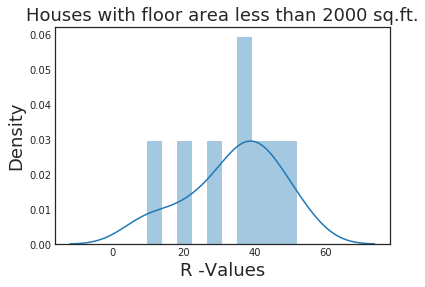

In [4]:
my_series = weather_df[ (weather_df['conditions_square_foot'] >  2000  )&  (weather_df['year_built'] <  2000  )  ]['total_r_value_of_attic'].dropna() 

# sns.distplot(my_series,  rug=True, kde=True, hist=False)
sns.distplot(my_series ,   10)

plt.xlabel('R -Values', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Houses with floor area less than 2000 sq.ft.', fontsize=18)

/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

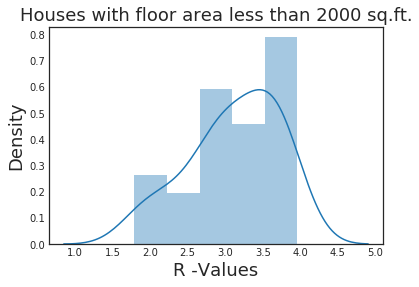

In [5]:
sns.distplot(weather_df[  (weather_df['year_built']<2000)]['total_r_value_of_attic'].dropna().apply(np.log) )
plt.title('Houses with floor area less than 2000 sq.ft.', fontsize=18)
plt.xlabel('R -Values', fontsize=18)
plt.ylabel('Density', fontsize=18)

/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

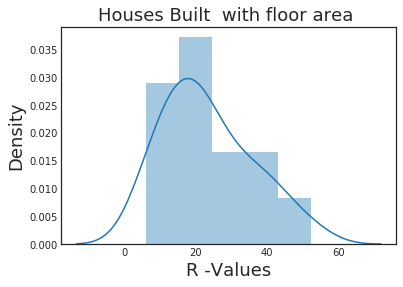

In [6]:
fig = sns.distplot( weather_df[  (weather_df['conditions_square_foot']<2000)& (weather_df['year_built']<1990)]['total_r_value_of_attic'].dropna() , bins= 5)
plt.xlabel('R -Values', fontsize=18)
plt.title('Houses Built  with floor area ', fontsize=18)
plt.xlabel('R -Values', fontsize=18)
plt.ylabel('Density', fontsize=18)


/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

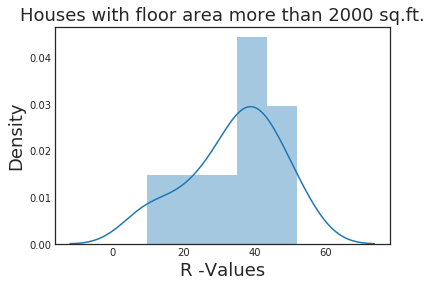

In [7]:
fig = sns.distplot(  weather_df[  (weather_df['conditions_square_foot']>2000)& (weather_df['year_built']<2000)]['total_r_value_of_attic'].dropna() , bins= 5)
plt.xlabel('R -Values', fontsize=18)
plt.title('Houses with floor area more than 2000 sq.ft.', fontsize=18)
plt.xlabel('R -Values', fontsize=18)
plt.ylabel('Density', fontsize=18)

In [8]:
weather_df['total_r_value_of_attic'].dropna().mean()

32.08269230769231

In [9]:
weather_df[weather_df['year_built'] > 1970]['total_r_value_of_attic'].dropna().mean()

38.67142857142857

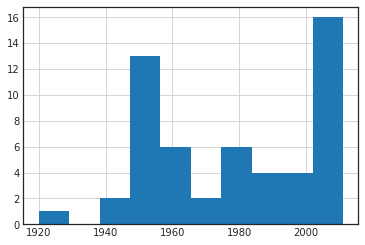

In [10]:
weather_df['year_built'].hist()

In [11]:
weather_df['total_r_value_of_attic'].dropna().count()

52

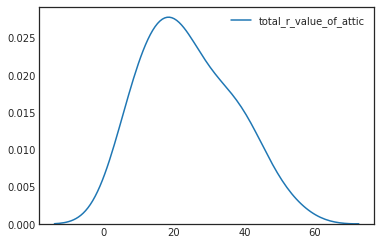

In [12]:
x = weather_df[weather_df['year_built'] < 1990]['total_r_value_of_attic'].dropna()

sns.kdeplot(x)

In [13]:
def neg_loglike(theta):
    mu = np.log(theta[0] * x)
    return -1*lognorm(mu, theta[1]).logpdf(x).sum()

In [14]:
theta_start = np.array([1.0,1.0])
res = minimize(neg_loglike, theta_start, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 149.331934
         Iterations: 50
         Function evaluations: 97


In [15]:
from scipy.stats import norm, lognorm
from numpy import linspace
from pylab import plot,show,hist,figure,title

samp=   weather_df[weather_df['year_built']<1990]['total_r_value_of_attic'].dropna()
param= lognorm.fit(samp) # fit the sample data
param

(0.34725839445035067, -12.000441621472026, 34.00832185591648)

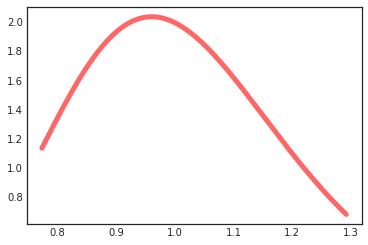

In [16]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)


s = 0.2
mean, var, skew, kurt = lognorm.stats(s, moments='mvsk')


x = np.linspace(lognorm.ppf(0.1, s),
                lognorm.ppf(.9, s), 1000)
ax.plot(x, lognorm.pdf(x, s), 'r-', lw=5, alpha=0.6, label='lognorm pdf')

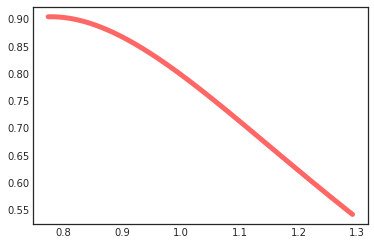

In [17]:
plt.plot(np.sort(x), lognorm.pdf(np.sort(x), 0.5),'r-', lw=5, alpha=0.6, label='lognorm pdf')

In [18]:
mean, var, skew, kurt = lognorm.stats(3, moments='mvsk')

In [19]:
mean, var, skew, kurt

(array(90.0171313),
 array(65651866.05340294),
 array(729551.3830466),
 array(4.31229584e+15))

In [20]:
Hfun = ndt.Hessian(neg_loglike, full_output=True)
hessian_ndt, info = Hfun(res['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))
results = pd.DataFrame({'parameters':res['x'],'std err':se})
results.index=['Mean','Sigma' ]   
results.head()

NameError: name 'ndt' is not defined

In [ ]:
μ = np.mean(np.log(x))

In [ ]:
σ = np.mean( (np.log(x) - np.mean(np.log(x)))**2 )

In [ ]:
np.exp(μ  +  σ**2//2)

In [ ]:
np.sqrt((np.exp(σ**2)-1) *  np.exp(2 * μ + σ**2))


In [ ]:
x = weather_df[weather_df['year_built'] <1990]['total_r_value_of_attic'].dropna()

sns.kdeplot(x)

In [ ]:
sns.distplot(samp,   10)

In [ ]:
param= lognorm.fit(samp, floc=0)

In [ ]:
x=np.linspace(0,1,31)
pdf_fitted =  lognorm.pdf(x, param[0], loc=param[1], scale=param[2]) # fitted distribution
plt.plot(x,pdf_fitted,'r-')
plt.hist(samp,bins=10,normed=True,alpha=.3)

In [ ]:
param= lognorm.fit(samp)
pdf_fitted =  lognorm.pdf(x, param[0], loc=param[1], scale=param[2]) # fitted distribution

plt.plot(x,pdf_fitted,'r-')


# Create a Maximum Likelihood Estimator for LogNormal Distribution

In [21]:
class logNormalParams():
    
    def __init__(self,  X,   *args, **kwargs):
        self.X = X
  
    
    def likelihood(self):
        μ = np.mean(np.log(self.X))
        σ = np.sqrt(np.mean((np.log(self.X) - μ)**2 ))
        
        mean = np.exp(μ  + σ**2//2)
        sd = np.sqrt((np.exp(σ**2)-1) *  np.exp(2 * μ + σ**2))

        
        return (mean, sd, μ, σ)

# Estimation for large buildings

In [22]:
data = weather_df[ (weather_df['conditions_square_foot'] >  2000  )&  (weather_df['year_built'] <  2000  )  ]['total_r_value_of_attic'].dropna() 

dist = logNormalParams(data)

(mean, sd, μ, σ) = dist.likelihood()

(mean, sd, μ, σ)

(30.981823668238697,
 18.666672346893023,
 3.4334006992419437,
 0.49916158712152714)

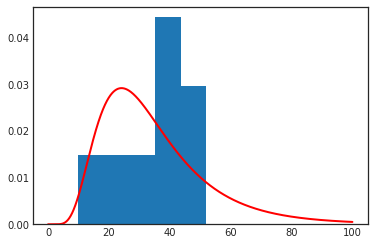

In [58]:
import matplotlib.pyplot as plt
import scipy.special as sps

x = np.linspace(0, 100, 10000)
s = data
count, bins, ignored = plt.hist(s, 5, density=True)
pdf = (np.exp(-(np.log(x) - (μ ))**2 / (2 * σ**2))  / (x * σ * np.sqrt(2 * np.pi)))
plt.plot(x, pdf,  linewidth=2, color='r')
plt.show()

# Add the plot code here 

In [ ]:
def drange(start, stop, step):
    while start < stop:
            yield start
            start += step
color = [  '#3DF735', '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#F6CC1D']

j = 0
for i in  drange(-2.0,2.0,.5):
    s = np.random.lognormal(μ+i, σ, 1000)

    x = np.linspace(0, 100, 10000)

    pdf = (np.exp(-(np.log(x) - (μ+i))**2 / (2 * σ**2))  / (x * σ * np.sqrt(2 * np.pi)))

    # count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
    plt.plot(x, pdf, linewidth=2, color = color[j] , label =  'μ = ' + str(round(μ + i,2)) + ', σ = ' + str(round(σ,2)))
    plt.xlabel('R-values', fontsize = 20)
    plt.ylabel('PDF', fontsize = 20)
    plt.legend(loc='upper right')
    j = j + 1
plt.show()


In [ ]:
np.log(20.474121275130713)

# Gamma fit data

In [ ]:
import scipy.special as sps

class gammaParams:
    
    def __init__(self,  X,   *args, **kwargs):
        self.X = X
      
    
    def likelihood(self):
        
        s = np.log(np.mean(self.X)) - np.mean(np.log(self.X))
        
        knew = (3.0 - s + np.sqrt((s - 2)**2 + 24*s))/ (12 * s)
        kold = 1000000   
        
        
        while np.abs(knew - kold) > 0.000001:
             
            kold = knew
            knew = kold - ( np.log(kold) - sps.digamma(kold) - s)/ (1/kold - sps.polygamma(1, kold))
            
        k = knew
        θ = np.mean((self.X))/k
        mean = k * θ
        sd = np.sqrt(k * θ**2)
        
        return (mean , sd, k , θ)

In [ ]:

data = weather_df[ (weather_df['conditions_square_foot'] >  2000  )&  (weather_df['year_built'] <  2000  )  ]['total_r_value_of_attic'].dropna() 

dist = gammaParams(data)

(mean , sd, k , θ) = dist.likelihood()

(mean , sd, k , θ)

In [ ]:
x = np.linspace(0, 100, 10000)
s =  data 
count, bins, ignored = plt.hist(s, 9999, density=True)
pdf = bins**(k-1)*(np.exp(-bins/θ) / (sps.gamma(k)*θ**k))
plt.plot(x, pdf,  linewidth=2, color='r')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scipy.special as sps

x = np.linspace(0, 100, 10000)
s = data
count, bins, ignored = plt.hist(s, 9999, density=True)
pdf = bins**(k-1)*(np.exp(-bins/θ) / (sps.gamma(k)*θ**k))
plt.plot(x, pdf,  linewidth=2, color='r')
plt.show()

# Using Pymc3

In [92]:
x =  weather_df[ (weather_df['conditions_square_foot'] <  5000  )&  (weather_df['year_built'] <  5000  )  ]['total_r_value_of_attic'].dropna() 


In [93]:
with pm.Model() as model:
    D1 = pm.Dirichlet('D1', np.array([1. ,1.]))

 
    
    
    C1 = pm.Lognormal.dist( mu = 3.019161711852641, sd = 0.586945344041912)
    C2 = pm.Lognormal.dist( mu = 3.4334006992419437, sd = 0.49916158712152714)

    C = pm.Mixture('C', D1,  [C1 , C2], observed = x )

In [94]:
with model:
    advi = pm.ADVI()
    infer = advi.fit(30000)

Average Loss = 218.52: 100%|██████████| 30000/30000 [00:14<00:00, 2033.58it/s]
Finished [100%]: Average Loss = 218.52


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f3a7f1ba8>,
      dtype=object)

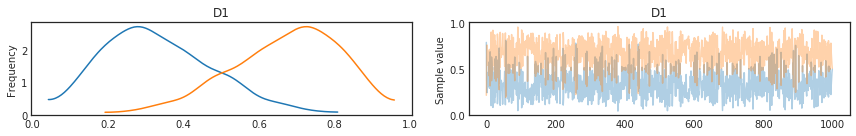

In [95]:
trace = infer.sample(1000)
pm.traceplot(trace)

/home/nilavro/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


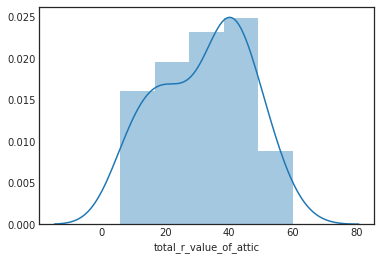

In [97]:
sns.distplot(x)